# 变量的保存与恢复
**tf.train.Checkpoint**

Checkpoint 只保存模型的参数，不保存模型的计算过程，因此一般用于在具有模型源代码的时候恢复之前训练好的模型参数。如果需要导出模型（无需源代码也能运行模型），请使用SavedModel.

TensorFlow 提供了 tf.train.Checkpoint 这一强大的变量保存与恢复类，
可以使用其 save() 和 restore() 方法将 TensorFlow 中所有包含 Checkpointable State 的对象进行保存和恢复。
具体而言，tf.keras.optimizer 、 tf.Variable 、 tf.keras.Layer 或者 tf.keras.Model 实例都可以被保存。

```
相关函数：
tf.train.Checkpoint(**kwargs)
checkpoint.save(save_path_with_prefix) # save_path_with_prefix是保存文件的'目录+前缀'
checkpoint.restore(save_path_with_prefix_and_index)　# save_path_with_prefix_and_index是之前保存的文件的'目录+前缀+编号'
```

关于checkpoint.save()的说明:
* 在源代码目录建立一个名为 save 的文件夹并调用一次 checkpoint.save('./save/model.ckpt') ，
* 可以在 save 目录下发现名为 checkpoint 、 model.ckpt-1.index 、 model.ckpt-1.data-00000-of-00001 的三个文件，这些文件记录了变量信息
* checkpoint.save() 方法可以运行多次，每运行一次都会得到一个.index 文件和.data 文件，序号依次累加。

关于checkpoint.restore()的说明:
* 参数save_path_with_prefix_and_index 是之前保存的文件的目录 + 前缀 + 编号。
* 例如，调用 checkpoint.restore('./save/model.ckpt-1')就可以载入前缀为 model.ckpt,序号为 1 的文件来恢复模型。
* 可以使用 tf.train.latest_checkpoint(save_path) 返回目录下最近一次 checkpoint 的文件名

使用checkpoint保存参数

```
save_path_with_prefix = './save/model.ckpt'
model = MyModel()
optimizer = MyOptimizer()

# 声明一个 Checkpoint; # 以键名'myModel'和'myOptimizer'保存模型和优化器
checkpoint = tf.train.Checkpoint(myModel=model, myOptimizer=optimizer) 

pass # model训练...

# 在要保存的时候执行save()
checkpoint.save(save_path_with_prefix)
```

使用checkpoint载入参数
```
model_to_be_restored = MyModel()                                  # 待恢复参数的同一模型
checkpoint = tf.train.Checkpoint(myModel=model_to_be_restored)   # 键名保持为'myModel'
save_path_with_prefix_and_index = tf.train.latest_checkpoint('./save/')
checkpoint.restore(save_path_with_prefix_and_index)
```

 总体而言，恢复与保存变量的典型代码框架如下
```
# train.py 模型训练阶段
model = MyModel()
# 实例化Checkpoint，指定保存对象为model（如果需要保存Optimizer的参数也可加入）
checkpoint = tf.train.Checkpoint(myModel=model)
# ...（模型训练代码）
# 模型训练完毕后将参数保存到文件（也可以在模型训练过程中每隔一段时间就保存一次）
checkpoint.save('./save/model.ckpt')


# test.py 模型使用阶段
model = MyModel()
checkpoint = tf.train.Checkpoint(myModel=model)             # 实例化Checkpoint，指定恢复对象为model
checkpoint.restore(tf.train.latest_checkpoint('./save'))    # 从文件恢复模型参数
# 模型使用代码
```

在模型的训练过程中，我们往往每隔一定步数保存一个 Checkpoint 并进行编号。不过很多时候我们会有这样的需求：
在长时间的训练后，程序会保存大量的 Checkpoint，但我们只想保留最后的几个 Checkpoint；
并且我们希望使用当前 Batch 的编号作为文件编号。
这时，我们可以使用 TensorFlow 的 tf.train.CheckpointManager 来实现以上需求。
具体而言，在定义 Checkpoint 后接着定义一个 CheckpointManager：
```
checkpoint = tf.train.Checkpoint(model=model)
manager = tf.train.CheckpointManager(checkpoint, directory='./save', \
                                     checkpoint_name='model.ckpt', max_to_keep=k)
...
manager.save(checkpoint_number=batch_index)
```
tf.train.CheckpointManager参数说明:
* directory: 文件保存的路径
* checkpoint_name: 为文件名前缀（不提供则默认为 ckpt ）
* max_to_keep:保留多少个Checkpoint文件

In [ ]:
# 例子：　展示模型变量的保存和载入

import tensorflow as tf
import numpy as np
import argparse
from zh.model.mnist.mlp import MLP
from zh.model.utils import MNISTLoader

parser = argparse.ArgumentParser(description='Process some integers.')
parser.add_argument('--mode', default='train', help='train or test')
parser.add_argument('--num_epochs', default=1)
parser.add_argument('--batch_size', default=50)
parser.add_argument('--learning_rate', default=0.001)
args = parser.parse_args()
data_loader = MNISTLoader()


def train():
    model = MLP()
    optimizer = tf.keras.optimizers.Adam(learning_rate=args.learning_rate)
    num_batches = int(data_loader.num_train_data // args.batch_size * args.num_epochs)
    
    checkpoint = tf.train.Checkpoint(myAwesomeModel=model)      
    # 使用tf.train.CheckpointManager管理Checkpoint
    manager = tf.train.CheckpointManager(checkpoint, directory='./save', max_to_keep=3)
    
    for batch_index in range(1, num_batches):
        X, y = data_loader.get_batch(args.batch_size)
        with tf.GradientTape() as tape:
            y_pred = model(X)
            loss = tf.keras.losses.sparse_categorical_crossentropy(y_true=y, y_pred=y_pred)
            loss = tf.reduce_mean(loss)
            print("batch %d: loss %f" % (batch_index, loss.numpy()))
        grads = tape.gradient(loss, model.variables)
        optimizer.apply_gradients(grads_and_vars=zip(grads, model.variables))
        if batch_index % 100 == 0:
            # 使用CheckpointManager保存模型参数到文件并自定义编号
            path = manager.save(checkpoint_number=batch_index)         
            print("model saved to %s" % path)


def test():
    model_to_be_restored = MLP()
    checkpoint = tf.train.Checkpoint(myAwesomeModel=model_to_be_restored)      
    checkpoint.restore(tf.train.latest_checkpoint('./save'))
    y_pred = np.argmax(model_to_be_restored.predict(data_loader.test_data), axis=-1)
    print("test accuracy: %f" % (sum(y_pred == data_loader.test_label) / data_loader.num_test_data))


if __name__ == '__main__':
    if args.mode == 'train':
        train()
    if args.mode == 'test':
        test()

# TensorBoard：训练过程可视化

**实时查看参数变化情况** 

保存可视化数据整体框架如下
```
# 实例化一个记录器,参数为记录文件所保存的目录
summary_writer = tf.summary.create_file_writer('./tensorboard_dataDir')

# 开始模型训练
for batch_index in range(num_batches):
    # ...（训练代码，当前batch的损失值放入变量loss中）
    with summary_writer.as_default():                               # 希望使用的记录器
        tf.summary.scalar("loss", loss, step=batch_index)
        tf.summary.scalar("MyScalar", my_scalar, step=batch_index)  # 还可以添加其他自定义的变量

```

打开可视化服务tensorboard：
    在代码目录打开终端cmd，运行: tensorboard --logdir=./tensorboard_dataDir --host=127.0.0.1

查看可视化结果:
    浏览器访问命令行程序所输出的网址（一般是 http://name-of-your-computer:6006）

## 查看 Graph 和 Profile 信息

可以在训练时使用 tf.summary.trace_on 开启 Trace，此时 TensorFlow 会将训练时的大量信息（如计算图的结构，每个操作所耗费的时间等）记录下来。在训练完成后，使用 tf.summary.trace_export 将记录结果输出到文件

```
tf.summary.trace_on(graph=True, profiler=True)  # 开启Trace，可以记录图结构和profile信息

# 进行训练...

with summary_writer.as_default():
    tf.summary.trace_export(name="model_trace", step=0, profiler_outdir=log_dir)    # 保存Trace信息到文件
```


之后，我们就可以在 TensorBoard 中选择 “Profile”，以时间轴的方式查看各操作的耗时情况。如果使用了 tf.function 建立了计算图，也可以点击 “Graphs” 查看图结构。

In [ ]:
# 例子： 展示 TensorBoard 的使用

import tensorflow as tf
from zh.model.mnist.mlp import MLP
from zh.model.utils import MNISTLoader

num_batches = 1000
batch_size = 50
learning_rate = 0.001
log_dir = 'tensorboard'
model = MLP()
data_loader = MNISTLoader()
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

summary_writer = tf.summary.create_file_writer(log_dir)     # 实例化记录器
tf.summary.trace_on(profiler=True)  # 开启Trace（可选）

for batch_index in range(num_batches):
    X, y = data_loader.get_batch(batch_size)
    with tf.GradientTape() as tape:
        y_pred = model(X)
        loss = tf.keras.losses.sparse_categorical_crossentropy(y_true=y, y_pred=y_pred)
        loss = tf.reduce_mean(loss)
        print("batch %d: loss %f" % (batch_index, loss.numpy()))
        
        with summary_writer.as_default():                           # 指定记录器
            tf.summary.scalar("loss", loss, step=batch_index)       # 将当前损失函数的值写入记录器
            
    grads = tape.gradient(loss, model.variables)
    optimizer.apply_gradients(grads_and_vars=zip(grads, model.variables))
    
with summary_writer.as_default():
    tf.summary.trace_export(name="model_trace", step=0, profiler_outdir=log_dir)    # 保存Trace信息到文件（可选）

# 数据集的构建与预处理
**tf.data**： 帮助我们快速、高效地构建数据输入的流水线，尤其适用于数据量巨大的场景。

最基础的建立 tf.data.Dataset 的方法是使用 tf.data.Dataset.from_tensor_slices() ，适用于数据量较小（能够整个装进内存）的情况。


当提供多个张量作为输入时，张量的第 0 维(shape[0])大小必须相同，且必须将多个张量作为元组（Tuple，即使用 Python 中的小括号）拼接并作为输入。

In [ ]:
import tensorflow as tf
import numpy as np

X = tf.constant([2013, 2014, 2015, 2016, 2017])
Y = tf.constant([12000, 14000, 15000, 16500, 17500])

# 也可以使用NumPy数组，效果相同
# X = np.array([2013, 2014, 2015, 2016, 2017])
# Y = np.array([12000, 14000, 15000, 16500, 17500])

dataset = tf.data.Dataset.from_tensor_slices((X, Y))

for x, y in dataset:
    print(x.numpy(), y.numpy()) 

In [19]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt 


(train_data, train_label), (_, _) = tf.keras.datasets.mnist.load_data()
train_data = np.expand_dims(train_data.astype(np.float32) / 255.0, axis=-1)      # [60000, 28, 28, 1]
mnist_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_label))

tmp_ds = mnist_dataset.take(8)
tmp_ds
# for image, label in tmp_ds:
#     plt.title(label.numpy())
#     plt.imshow(image.numpy()[:, :, 0])
#     plt.show()

<TakeDataset shapes: ((28, 28, 1), ()), types: (tf.float32, tf.uint8)>

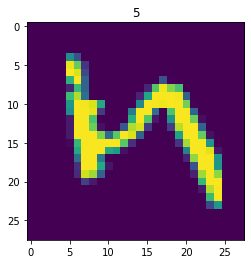

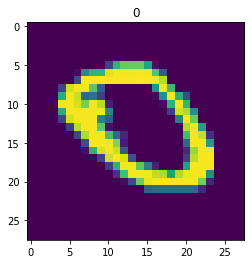

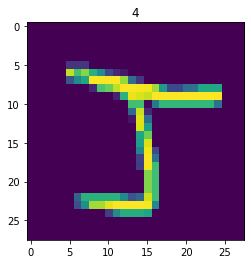

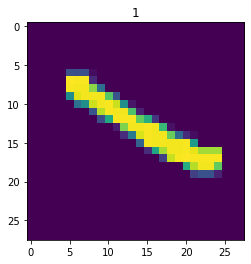

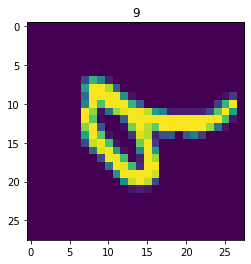

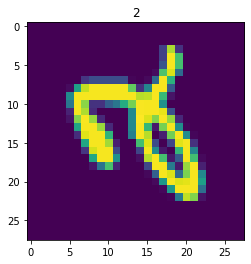

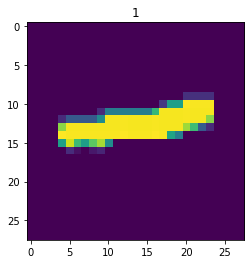

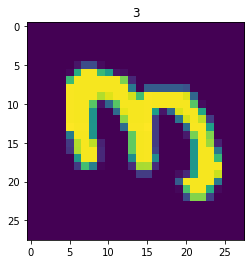

In [21]:
# 使用 Dataset.map() 将所有图片旋转 90 度：

def rot90(image, label):
    image = tf.image.rot90(image)
    return image, label

tmp_ds2 = tmp_ds.map(rot90)

for image, label in tmp_ds2:
    plt.title(label.numpy())
    plt.imshow(image.numpy()[:, :, 0])
    plt.show()


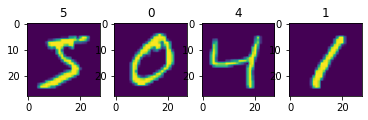

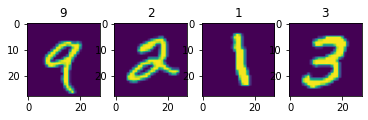

In [22]:
# 用 Dataset.batch() 将数据集划分批次，每个批次的大小为 4：

tmp_ds3 = tmp_ds.batch(4)

for images, labels in tmp_ds3:    # image: [4, 28, 28, 1], labels: [4]
    fig, axs = plt.subplots(1, 4)
    for i in range(4):
        axs[i].set_title(labels.numpy()[i])
        axs[i].imshow(images.numpy()[i, :, :, 0])
    plt.show()

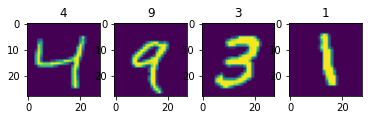

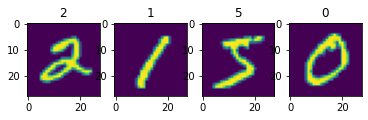

In [25]:
# 使用 Dataset.shuffle() 将数据打散后再设置批次，缓存大小设置为 10：

tmp_ds3 = tmp_ds.shuffle(buffer_size=10).batch(4)

for images, labels in tmp_ds3:
    fig, axs = plt.subplots(1, 4)
    for i in range(4):
        axs[i].set_title(labels.numpy()[i])
        axs[i].imshow(images.numpy()[i, :, :, 0])
    plt.show()

**Dataset.shuffle() 时缓冲区大小 buffer_size 的设置**
tf.data.Dataset 作为一个针对大规模数据设计的迭代器，本身无法方便地获得自身元素的数量或随机访问元素。
为了高效且较为充分地打散数据集，Dataset.shuffle() 采取了以下方法：
* 设定一个固定大小为 buffer_size 的缓冲区（Buffer）；
* 初始化时，取出数据集中的前 buffer_size 个元素放入缓冲区；
* 每次需要从数据集中取元素时，即从缓冲区中随机采样一个元素并取出，然后从后续的元素中取出一个放回到之前被取出的位置，以维持缓冲区的大小。

因此，缓冲区的大小需要根据数据集的特性和数据排列顺序特点来进行合理的设置。比如：
* 当 buffer_size 设置为 1 时，其实等价于没有进行任何打散；
* 当数据集的标签顺序分布极为不均匀（例如二元分类时数据集前 N 个的标签为 0，后 N 个的标签为 1）时，较小的缓冲区大小会使得训练时取出的 Batch 数据很可能全为同一标签，从而影响训练效果。一般而言，数据集的顺序分布若较为随机，则缓冲区的大小可较小，否则则需要设置较大的缓冲区。

**数据集元素的获取与使用** 

```
# 使用 For 循环迭代获取数据
dataset = tf.data.Dataset.from_tensor_slices((A, B, C, ...))
for a, b, c, ... in dataset:
    # 对张量a, b, c等进行操作，例如送入模型进行训练

    
# 使用 iter() 显式创建一个 Python 迭代器并使用 next() 获取下一个元素
dataset = tf.data.Dataset.from_tensor_slices((A, B, C, ...))
it = iter(dataset)
a_0, b_0, c_0, ... = next(it)
a_1, b_1, c_1, ... = next(it)


# Keras 支持使用 tf.data.Dataset 直接作为tf.keras.Model fit()和evaluate()的输入。当调用时将参数中的输入数据x指定为一个元素格式为 (输入数据, 标签数据) 的 Dataset。
# 常规的 Keras 训练方式是：
model.fit(x=train_data, y=train_label, epochs=num_epochs, batch_size=batch_size)
# 使用 tf.data.Dataset 后
model.fit(mnist_dataset, epochs=num_epochs) # batch_size已经通过Dataset.batch()设置了，所以这里也无需提供batch_size参数。

```

In [ ]:
# 示例： 展示了使用tf.data结合tf.io和tf.image建立tf.data.Dataset数据集，并进行训练和测试的完整过程

import tensorflow as tf
import os

num_epochs = 10
batch_size = 32
learning_rate = 0.001
data_dir = 'D:/myProject/MachineLearning_WKS/fastai_datasets_cats_vs_dogs_2'
train_cats_dir = data_dir + '/train/cats/'
train_dogs_dir = data_dir + '/train/dogs/'
test_cats_dir = data_dir + '/valid/cats/'
test_dogs_dir = data_dir + '/valid/dogs/'

def _decode_and_resize(filename, label):
    image_string = tf.io.read_file(filename)            # 读取原始文件
    image_decoded = tf.image.decode_jpeg(image_string)  # 解码JPEG图片
    image_resized = tf.image.resize(image_decoded, [256, 256]) / 255.0
    return image_resized, label

if __name__ == '__main__':
    # 构建训练数据集
    train_cat_filenames = tf.constant([train_cats_dir + filename for filename in os.listdir(train_cats_dir)])
    train_dog_filenames = tf.constant([train_dogs_dir + filename for filename in os.listdir(train_dogs_dir)])
    train_filenames = tf.concat([train_cat_filenames, train_dog_filenames], axis=-1)
    train_labels = tf.concat([
        tf.zeros(train_cat_filenames.shape, dtype=tf.int32), 
        tf.ones(train_dog_filenames.shape, dtype=tf.int32)], 
        axis=-1)

    train_dataset = tf.data.Dataset.from_tensor_slices((train_filenames, train_labels))
    train_dataset = train_dataset.map(
        map_func=_decode_and_resize, 
        num_parallel_calls=tf.data.experimental.AUTOTUNE)
    # 取出前buffer_size个数据放入buffer，并从其中随机采样，采样后的数据用后续数据替换
    train_dataset = train_dataset.shuffle(buffer_size=23000)    
    train_dataset = train_dataset.batch(batch_size)
    train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, 3, activation='relu', input_shape=(256, 256, 3)),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(32, 5, activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(2, activation='softmax')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss=tf.keras.losses.sparse_categorical_crossentropy,
        metrics=[tf.keras.metrics.sparse_categorical_accuracy]
    )

    model.fit(train_dataset, epochs=num_epochs)
    


In [ ]:
# 构建测试数据集
test_cat_filenames = tf.constant([test_cats_dir + filename for filename in os.listdir(test_cats_dir)])
test_dog_filenames = tf.constant([test_dogs_dir + filename for filename in os.listdir(test_dogs_dir)])
test_filenames = tf.concat([test_cat_filenames, test_dog_filenames], axis=-1)
test_labels = tf.concat([
    tf.zeros(test_cat_filenames.shape, dtype=tf.int32), 
    tf.ones(test_dog_filenames.shape, dtype=tf.int32)], 
    axis=-1)

test_dataset = tf.data.Dataset.from_tensor_slices((test_filenames, test_labels))
test_dataset = test_dataset.map(_decode_and_resize)
test_dataset = test_dataset.batch(batch_size)

print(model.metrics_names)
print(model.evaluate(test_dataset))

In [26]:
data_dir = 'D:/myProject/MachineLearning_WKS/fastai_datasets_cats_vs_dogs_2'
train_cats_dir = data_dir + '/train/cats/'
train_dogs_dir = data_dir + '/train/dogs/'
test_cats_dir = data_dir + '/valid/cats/'
test_dogs_dir = data_dir + '/valid/dogs/'

# TFRecord ：TensorFlow 数据集存储格式

TFRecord 可以理解为一系列序列化的 tf.train.Example 元素所组成的列表文件，
而每一个 tf.train.Example 又由若干个 tf.train.Feature 的字典组成。形式如下：
``` 
# dataset.tfrecords
[
    {   # example 1 (tf.train.Example)
        'feature_1': tf.train.Feature,
        ...
        'feature_k': tf.train.Feature
    },
    ...
    {   # example N (tf.train.Example)
        'feature_1': tf.train.Feature,
        ...
        'feature_k': tf.train.Feature
    }
]
```

为了将形式各样的数据集整理为TFRecord格式，需要对数据集中的每个元素进行以下步骤：
1. 读取该数据元素到内存；
2. 将该元素转换为tf.train.Example对象(每一个tf.train.Example由
   若干个tf.train.Feature的字典组成，因此需要先建立 Feature的字典)；
3. 将该tf.train.Example对象序列化为字符串，并通过一个
   预先定义的 tf.io.TFRecordWriter 写入 TFRecord 文件。

而读取 TFRecord 数据则可按照以下步骤：
1. 通过tf.data.TFRecordDataset读入原始的TFRecord文件（此时文件中的 tf.train.Example 对象尚未被反序列化），
   获得一个 tf.data.Dataset 数据集对象；
2. 通过Dataset.map方法，对该数据集对象中的每一个序列化的tf.train.Example字符串
   执行tf.io.parse_single_example函数，从而实现反序列化。
   
   
tf.train.Feature 支持三种数据格式：
* tf.train.BytesList ：字符串或原始 Byte 文件（如图片），
  通过 bytes_list 参数传入一个由字符串数组初始化的 tf.train.BytesList 对象；
* tf.train.FloatList ：浮点数，通过 float_list 参数传入一个由浮点数数组初始化的 tf.train.FloatList 对象；
* tf.train.Int64List ：整数，通过 int64_list 参数传入一个由整数数组初始化的 tf.train.Int64List 对象。

In [51]:
import tensorflow as tf
import os

data_dir = 'D:/myProject/MachineLearning_WKS/fastai_datasets_cats_vs_dogs_2'
train_cats_dir = data_dir + '/train/cats/'
train_dogs_dir = data_dir + '/train/dogs/'
tfrecord_file_one = data_dir + '/train/train_one.tfrecords'
tfrecord_file_batch = data_dir + '/train/train_batch.tfrecords'

train_cat_filenames = [train_cats_dir + filename for filename in os.listdir(train_cats_dir)]
train_dog_filenames = [train_dogs_dir + filename for filename in os.listdir(train_dogs_dir)]
train_filenames = train_cat_filenames + train_dog_filenames
# 将 cat 类的标签设为0，dog 类的标签设为1
train_labels = [0] * len(train_cat_filenames) + [1] * len(train_dog_filenames)  

In [193]:
# 示例: 将数据集存储为TFRecord文件. --该示例中Example只包含一个样本，实际使用时可以包含一批样本
with tf.io.TFRecordWriter(tfrecord_file_one) as writer:
    for filename, label in zip(train_filenames, train_labels):
        image = open(filename, 'rb').read()     # 读取数据集图片到内存，image 为一个 Byte 类型的字符串
        feature = {                             # 建立 tf.train.Feature 字典
            'image': tf.train.Feature(bytes_list=tf.train.BytesList(value=[image])),  # 图片是一个 Bytes 对象
            'label': tf.train.Feature(int64_list=tf.train.Int64List(value=[label]))   # 标签是一个 Int 对象
        }
        example = tf.train.Example(features=tf.train.Features(feature=feature)) # 通过字典建立 Example
        writer.write(example.SerializeToString())   # 将Example序列化并写入 TFRecord 文件
        
        
# 示例: 将数据集存储为TFRecord文件. --该示例中Example包含batch_size个样本
batch_size = 4
with tf.io.TFRecordWriter(tfrecord_file_batch) as writer:
    count = 0
    batch_images = []
    batch_labels = []
    for filename, label in zip(train_filenames, train_labels):
        count += 1
        image = open(filename, 'rb').read()     # 读取数据集图片到内存，image 为一个 Byte 类型的字符串
        batch_images.append(image)
        batch_labels.append(label)
        if count == batch_size:
            count = 0
            feature = {                             # 建立 tf.train.Feature 字典
                'image': tf.train.Feature(bytes_list=tf.train.BytesList(value=batch_images)),  # 图片是一个 Bytes 对象
                'label': tf.train.Feature(int64_list=tf.train.Int64List(value=batch_labels))   # 标签是一个 Int 对象
            }
            example = tf.train.Example(features=tf.train.Features(feature=feature)) # 通过字典建立 Example
            writer.write(example.SerializeToString())   # 将Example序列化并写入 TFRecord 文件
            batch_images.clear()
            batch_labels.clear()

In [128]:
# 读取TFRecord文件 -- 单个Example只包含一个样本时
raw_dataset = tf.data.TFRecordDataset(tfrecord_file_one)    # 读取 TFRecord 文件

feature_description = { # 定义Feature结构，告诉解码器每个Feature的类型是什么
    'image': tf.io.FixedLenFeature((), tf.string),
    'label': tf.io.FixedLenFeature((), tf.int64),
}

def _parse_example(example_string): # 将 TFRecord 文件中的每一个序列化的 tf.train.Example 解码
    feature_dict = tf.io.parse_single_example(example_string, feature_description)
    feature_dict['image'] = tf.io.decode_jpeg(feature_dict['image'])    # 解码JPEG图片
    return feature_dict['image'], feature_dict['label']

dataset = raw_dataset.map(_parse_example)
tmp_ds = dataset.take(8)
for i, (image, label) in enumerate(tmp_ds):
    print('iter:', i, image.shape)

iter: 0 (374, 500, 3)
iter: 1 (280, 300, 3)
iter: 2 (499, 489, 3)
iter: 3 (499, 403, 3)
iter: 4 (149, 150, 3)
iter: 5 (359, 431, 3)
iter: 6 (374, 500, 3)
iter: 7 (471, 499, 3)


iter: 0 (4, 256, 256, 3)


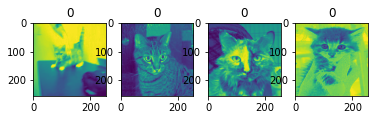

iter: 1 (4, 256, 256, 3)


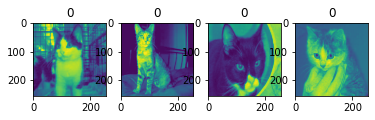

iter: 2 (4, 256, 256, 3)


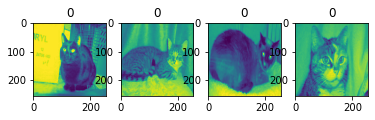

iter: 3 (4, 256, 256, 3)


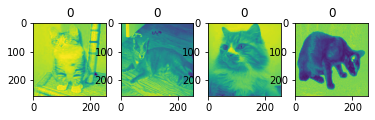

iter: 4 (4, 256, 256, 3)


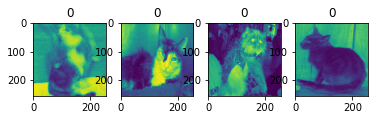

iter: 5 (4, 256, 256, 3)


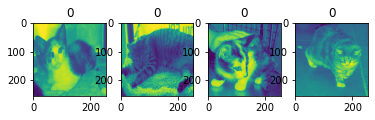

iter: 6 (4, 256, 256, 3)


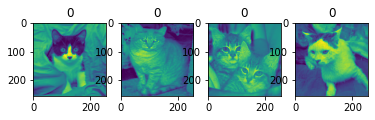

iter: 7 (4, 256, 256, 3)


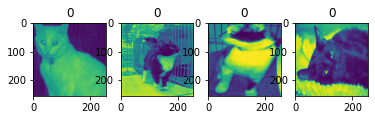

In [231]:
# 读取TFRecord文件 -- 单个Example包含一批样本时
raw_dataset = tf.data.TFRecordDataset(tfrecord_file_batch)    # 读取 TFRecord 文件

feature_description = { # 定义Feature结构，告诉解码器每个Feature的类型是什么
    'image': tf.io.FixedLenFeature((batch_size,), tf.string),
    'label': tf.io.FixedLenFeature((batch_size,), tf.int64),
}

# _parse_example1与_parse_example2实现同样的功能
def _parse_example1(example_string): # 将 TFRecord 文件中的每一个序列化的 tf.train.Example 解码
    feature_dict = tf.io.parse_example(example_string, feature_description)
    img_lst = []
    for i in range(feature_dict['image'].shape[0]): # 解码JPEG图片
        img = tf.image.resize(tf.io.decode_jpeg(feature_dict['image'][i]), (256, 256))
        img_lst.append(img)
    feature_dict['image'] = tf.convert_to_tensor(img_lst)
    return feature_dict['image'], feature_dict['label']

def _parse_example2(example_string): # 将 TFRecord 文件中的每一个序列化的 tf.train.Example 解码
    feature_dict = tf.io.parse_example(example_string, feature_description)
    def fn(img):
        return tf.image.resize(tf.io.decode_jpeg(img), (256, 256))
    feature_dict['image'] = tf.map_fn(fn, feature_dict['image'], dtype=tf.float32)   
    return feature_dict['image'], feature_dict['label']


dataset = raw_dataset.map(_parse_example2)
tmp_ds = dataset.take(8)
for i, (images, labels) in enumerate(tmp_ds):
    print('iter:', i, images.shape)
#     for j,image in enumerate(images):
#         print('\tbatch_index:', j, image.shape)
           
    fig, axs = plt.subplots(1, batch_size)
    for i in range(batch_size):
        axs[i].set_title(labels.numpy()[i])
        axs[i].imshow(images.numpy()[i, :, :, 0])
    plt.show()

## tf.function ：图执行模式

TensorFlow2 我们提供了 tf.function 模块，结合 AutoGraph 机制，我们仅需添加 @tf.function 修饰符，就能将模型以图执行模式运行。



In [233]:
# 示例
import tensorflow as tf
import time
from zh.model.mnist.cnn import CNN
from zh.model.utils import MNISTLoader

num_batches = 1000
batch_size = 50
learning_rate = 0.001
data_loader = MNISTLoader()
model = CNN()
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

@tf.function
def train_one_step(X, y):    
    with tf.GradientTape() as tape:
        y_pred = model(X)
        loss = tf.keras.losses.sparse_categorical_crossentropy(y_true=y, y_pred=y_pred)
        loss = tf.reduce_mean(loss)
        # 注意这里使用了TensorFlow内置的tf.print()。@tf.function不支持Python内置的print方法
        tf.print("loss", loss)
    grads = tape.gradient(loss, model.variables)    
    optimizer.apply_gradients(grads_and_vars=zip(grads, model.variables))

start_time = time.time()
for batch_index in range(num_batches):
    X, y = data_loader.get_batch(batch_size)
    train_one_step(X, y)
end_time = time.time()
print(end_time - start_time)

### tf.function 内在机制 
当被 @tf.function 修饰的函数第一次被调用的时候，进行以下操作：
* 在即时执行模式关闭的环境下，函数内的代码依次运行。也就是说，每个 tf. 方法都只是定义了计算节点，而并没有进行任何实质的计算。这与 TensorFlow 1.X 的图执行模式是一致的；
* 使用 AutoGraph 将函数中的 Python 控制流语句转换成 TensorFlow 计算图中的对应节点（比如说 while 和 for 语句转换为 tf.while ， if 语句转换为 tf.cond 等等；
* 基于上面的两步，建立函数内代码的计算图表示（为了保证图的计算顺序，图中还会自动加入一些 tf.control_dependencies 节点）；
* 运行一次这个计算图；
* 基于函数的名字和输入的函数参数的类型生成一个哈希值，并将建立的计算图缓存到一个哈希表中

在被 @tf.function 修饰的函数之后再次被调用的时候，根据函数名和输入的函数参数的类型计算哈希值，检查哈希表中是否已经有了对应计算图的缓存。如果是，则直接使用已缓存的计算图，否则重新按上述步骤建立计算图.


**注**: 并不是任何函数都可以被 @tf.function 修饰！,@tf.function 使用静态编译将函数内的代码转换成计算图，因此对函数内可使用的语句有一定限制（仅支持 Python 语言的一个子集），且需要函数内的操作本身能够被构建为计算图。建议在函数内只使用 TensorFlow 的原生操作，不要使用过于复杂的 Python 语句，函数参数只包括 TensorFlow 张量或 NumPy 数组，并最好是能够按照计算图的思想去构建函数

In [242]:
import tensorflow as tf
import numpy as np

@tf.function
def f(x):
    print("The function is running in Python") #Python 内置的 print 则不能被转换成计算图的节点
    tf.print(x)

a = tf.constant(1, dtype=tf.int32)
f(a)
b = tf.constant(2, dtype=tf.int32)
f(b)
b_ = np.array(2, dtype=np.int32)
f(b_)
c = tf.constant(0.1, dtype=tf.float32)
f(c)
d = tf.constant(0.2, dtype=tf.float32)
f(d)

The function is running in Python
1
2
2
The function is running in Python
0.1
0.2


## AutoGraph：将 Python 控制流转换为 TensorFlow 计算图
tf.function 使用 AutoGraph 的机制将函数中的 Python 控制流语句转换成 TensorFlow 计算图中的对应节点

In [248]:
# 示例，使用 tf.autograph 模块的低层 API tf.autograph.to_code 将函数 square_if_positive 转换成 TensorFlow 计算图
import tensorflow as tf

@tf.function
def square_if_positive(x):
    if x > 0:
        x = x * x
    else:
        x = 0
    return x

a = tf.constant(1)
b = tf.constant(-1)
print(square_if_positive(a), square_if_positive(b))
print(tf.autograph.to_code(square_if_positive.python_function))

tf.Tensor(1, shape=(), dtype=int32) tf.Tensor(0, shape=(), dtype=int32)
def tf__square_if_positive(x):
  do_return = False
  retval_ = ag__.UndefinedReturnValue()
  with ag__.FunctionScope('square_if_positive', 'fscope', ag__.ConversionOptions(recursive=True, user_requested=True, optional_features=(), internal_convert_user_code=True)) as fscope:

    def get_state():
      return ()

    def set_state(_):
      pass

    def if_true():
      x_1, = x,
      x_1 = x_1 * x_1
      return x_1

    def if_false():
      x = 0
      return x
    cond = x > 0
    x = ag__.if_stmt(cond, if_true, if_false, get_state, set_state, ('x',), ())
    do_return = True
    retval_ = fscope.mark_return_value(x)
  do_return,
  return ag__.retval(retval_)



## 使用传统的 tf.Session

In [ ]:
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)
num_batches = int(data_loader.num_train_data // batch_size * num_epochs)
# 建立计算图
X_placeholder = tf.compat.v1.placeholder(name='X', shape=[None, 28, 28, 1], dtype=tf.float32)
y_placeholder = tf.compat.v1.placeholder(name='y', shape=[None], dtype=tf.int32)
y_pred = model(X_placeholder)
loss = tf.keras.losses.sparse_categorical_crossentropy(y_true=y_placeholder, y_pred=y_pred)
loss = tf.reduce_mean(loss)
train_op = optimizer.minimize(loss)
sparse_categorical_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
# 建立Session
with tf.compat.v1.Session() as sess:
    sess.run(tf.compat.v1.global_variables_initializer())
    for batch_index in range(num_batches):
        X, y = data_loader.get_batch(batch_size)
        # 使用Session.run()将数据送入计算图节点，进行训练以及计算损失函数
        _, loss_value = sess.run([train_op, loss], feed_dict={X_placeholder: X, y_placeholder: y})
        print("batch %d: loss %f" % (batch_index, loss_value))

    num_batches = int(data_loader.num_test_data // batch_size)
    for batch_index in range(num_batches):
        start_index, end_index = batch_index * batch_size, (batch_index + 1) * batch_size
        y_pred = model.predict(data_loader.test_data[start_index: end_index])
        sess.run(sparse_categorical_accuracy.update_state(y_true=data_loader.test_label[start_index: end_index], y_pred=y_pred))
    print("test accuracy: %f" % sess.run(sparse_categorical_accuracy.result()))

# tf.TensorArray ：TensorFlow 动态数组

* 在即时执行模式下，可以直接使用一个 Python 列表（List）存放张量.
* 在基于计算图的特性（例如使用 @tf.function 加速模型运行或者使用 SavedModel 导出模型），不能使用Python列表（List）存放张量;TensorFlow提供了tf.TensorArray，一种支持计算图特性的TensorFlow动态数组。


**请注意**，由于需要支持计算图， tf.TensorArray 的 write() 方法是不可以忽略左值的！
也就是说，在图执行模式下，必须按照以下的形式写入数组：
```
arr = arr.write(index, value)
```


tf.TensorArray的基本用法:
```
# 声明一个大小为size，元素类型为dtype的TensorArray arr 。
# 如果将 dynamic_size 参数设置为 True ，则该数组会自动增长空间。
arr = tf.TensorArray(dtype, size, dynamic_size=False)

# 将 value 写入数组的第 index 个位置
write(index, value)

# 读取数组的第 index 个值
read(index)

# 其它操作： stack() , unstack() ,...
```

In [249]:
# 示例

import tensorflow as tf

@tf.function
def array_write_and_read():
    arr = tf.TensorArray(dtype=tf.float32, size=3)
    arr = arr.write(0, tf.constant(0.0))
    arr = arr.write(1, tf.constant(1.0))
    arr = arr.write(2, tf.constant(2.0))
    arr_0 = arr.read(0)
    arr_1 = arr.read(1)
    arr_2 = arr.read(2)
    return arr_0, arr_1, arr_2

a, b, c = array_write_and_read()
print(a, b, c)

tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(2.0, shape=(), dtype=float32)


# tf.config：GPU 的使用与分配

## 指定当前程序使用的 GPU

默认情况下TensorFlow会使用其所能够使用的所有GPU; 当多个共用一台多GPU的工作站时,最好显式的分配显卡资源.

In [250]:
# 获取当前主机上某种特定运算设备类型（如 GPU 或 CPU ）的列表
gpus = tf.config.list_physical_devices(device_type='GPU')
cpus = tf.config.list_physical_devices(device_type='CPU')
print(gpus, cpus)

[] [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [ ]:
# 设置当前程序可见的设备范围（当前程序只会使用自己可见的设备，不可见的设备不会被当前程序使用）
tf.config.set_visible_devices(devices=gpus[0:2], device_type='GPU')

'''
使用环境变量 CUDA_VISIBLE_DEVICES 也可以控制程序所使用的 GPU。Linux 终端输入:
export CUDA_VISIBLE_DEVICES=2,3
或在代码中加入
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "2,3"
即可指定程序只在显卡 2,3 上运行。
'''

## 设置显存使用策略

TensorFlow 提供两种显存使用策略，让我们能够更灵活地控制程序的显存使用方式(默认情况下，TensorFlow 将使用几乎所有可用的显存)：
* 仅在需要时申请显存空间（程序初始运行时消耗很少的显存，随着程序的运行而动态申请显存）；
* 限制消耗固定大小的显存（程序不会超出限定的显存大小，若超出的报错）。

可以通过 tf.config.experimental.set_memory_growth 将 GPU 的显存使用策略设置为 “仅在需要时申请显存空间”。

In [ ]:
#  GPU 设置为仅在需要时申请显存空间
gpus = tf.config.list_physical_devices(device_type='GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(device=gpu, enable=True)

In [ ]:
# 设置 TensorFlow 固定消耗 GPU:0 的 1GB 显存(其实可以理解为建立了一个显存大小为 1GB 的 “虚拟 GPU”）
gpus = tf.config.list_physical_devices(device_type='GPU')
tf.config.set_logical_device_configuration(gpus[0],
    [tf.config.LogicalDeviceConfiguration(memory_limit=1024)])

## 单 GPU 模拟多 GPU 环境

In [ ]:
# 示例，在实体 GPU:0 的基础上建立了两个显存均为 2GB 的虚拟 GPU。
gpus = tf.config.list_physical_devices('GPU')
tf.config.set_logical_device_configuration(
    gpus[0],
    [tf.config.LogicalDeviceConfiguration(memory_limit=2048),
     tf.config.LogicalDeviceConfiguration(memory_limit=2048)])